In [1]:
import pandas as pd
import geopandas as gpd
import os
import gtfs_kit as gk
import osmnx as ox
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from shapely.geometry import Polygon, LineString
import warnings
warnings.filterwarnings('ignore')
import gtfs_kit as gk
import glob
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import Row, SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
from pyspark import SparkConf
import pandas as pd
import pickle
from tqdm import tqdm
pd.set_option('display.max_columns', None)

In [2]:
spark = SparkSession.builder.config('spark.executor.cores', '8').config('spark.executor.memory', '40g')\
        .config("spark.sql.session.timeZone", "UTC").config('spark.driver.memory', '40g').master("local[26]")\
        .appName("wego-daily").config('spark.driver.extraJavaOptions', '-Duser.timezone=UTC').config('spark.executor.extraJavaOptions', '-Duser.timezone=UTC')\
        .config("spark.sql.datetime.java8API.enabled", "true").config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.autoBroadcastJoinThreshold", -1)\
        .config("spark.driver.maxResultSize", 0)\
        .config("spark.shuffle.spill", "true")\
        .config("spark.driver.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")\
        .config("spark.executor.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")\
        .config("spark.ui.showConsoleProgress", "false")\
        .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

23/01/23 10:17:08 WARN Utils: Your hostname, Slade-173477 resolves to a loopback address: 127.0.1.1; using 10.2.219.10 instead (on interface eno1)
23/01/23 10:17:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/23 10:17:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/01/23 10:17:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
# apc_data = spark.read.load('data/tt_to_next_stop_2022_04_31.parquet')
# apc_data.createOrReplaceTempView("apc")

In [5]:
from shapely import wkt
waze_df = pd.read_csv('data/nashville_2020_2022.csv')
waze_df['geometry'] = waze_df['geo'].apply(wkt.loads)
waze_df = gpd.GeoDataFrame(waze_df, crs='epsg:4326')
# waze_df['datetime'] = pd.to_datetime()
cols = ['date', 'hour', 'minute', 'second']
waze_df['datetime'] = waze_df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
waze_df['datetime'] = pd.to_datetime(waze_df['datetime'], format="%Y-%m-%d %H %M %S")
waze_df = waze_df.query("type == 'ACCIDENT'")
waze_df.head(1)

,date,hour,minute,second,day_of_week,country,city,street,type,subtype,uuid,confidence,geo,reliability,magvar,reportrating,geometry,datetime
11,2022-01-18,15,48,29,3,US,"Nashville, TN",Murfreesboro Pike,ACCIDENT,ACCIDENT_MINOR,e7cc1409-8030-4137-bb3a-80bb5fd9621c,1,POINT(-86.588053 36.02618),7,319,3,POINT (-86.58805 36.02618),2022-01-18 15:48:29


In [122]:
listfiles = glob.glob('data/raw_gtfs/*.zip')
routes_arr = []
stops_arr = []
for lf in listfiles:
    feed = gk.read_feed(lf, dist_units='mi')
    routes = feed.geometrize_routes()
    stops = feed.geometrize_stops()
    routes_arr.append(routes)
    stops_arr.append(stops)
    
routes = pd.concat(routes_arr)
routes = routes.drop_duplicates()

stops = pd.concat(stops_arr)
stops = stops.drop_duplicates(subset='stop_id')
stops = stops.reset_index(drop=True)
stops

,stop_id,stop_code,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,geometry
0,10AHERNN,10AHERNN,10TH AVE N & HERMAN ST NB,10TH AV N & HERMAN ST,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-86.79234 36.16883)
1,11AWHESN,11AWHESN,11TH AVE N & WHEELESS ST SB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-86.80388 36.17900)
2,12AARCSF,12AARCSF,12TH AVE S & ARCHER ST SB,1037 12TH AVE & ARCHER ST,NaN,NaN,NaN,NaN,NaN,0.0,POINT (-86.78644 36.14507)
3,12AARCNN,12AARCNN,12TH AVE S & ARCHER ST,1025 12TH AVE & ARCHER ST,NaN,NaN,NaN,NaN,NaN,0.0,POINT (-86.78623 36.14522)
4,12ACALSN,12ACALSN,12TH AVE S & CALDWELL AVE SB,12TH AV S & CALDWELL AV,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-86.78880 36.13281)
...,...,...,...,...,...,...,...,...,...,...,...
2188,MURHMCSF,MURHMCSF,MURFREESBORO PIKE & HAMILTON CHURCH,NaN,NaN,NaN,0.0,NaN,NaN,NaN,POINT (-86.62820 36.06440)
2189,MURTHONN,MURTHONN,MURFREESBORO & THOMPSON PL NS,NaN,NaN,NaN,0.0,NaN,NaN,NaN,POINT (-86.70992 36.12598)
2190,NOLHICSN,NOLHICSN,NOLENSVILLE PIKE & HICKORY VIEW DR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-86.71385 36.04893)
2191,OLDHICHN,OLDHICHN,OLD HICKORY BLVD & HICKORY HILLS BL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-86.79575 36.27716)


32
32


<AxesSubplot: >

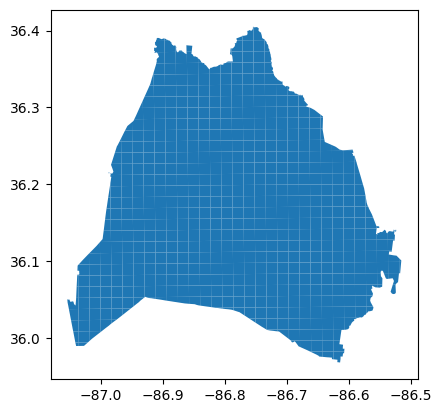

In [7]:
# maps
fp = os.path.join('data', 'shapefiles', "tncounty")
gdf_county = gpd.read_file(fp)
gdf_dav = gdf_county[gdf_county["NAME"] == "Davidson"]
# gdf_dav = gdf_dav.to_crs("EPSG:4326")
xmin, ymin, xmax, ymax = gdf_dav.total_bounds
gdf_dav.total_bounds
# gdf_dav.plot()
# GTFS

length = 5280 #feet
wide = 5280

cols = list(np.arange(xmin, xmax + wide, wide))
print(len(cols))
rows = list(np.arange(ymin, ymax + length, length))
print(len(rows))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
grids = grid.set_crs("EPSG:2274")
dav_grids = gpd.overlay(gdf_dav, grids, how='intersection')

dav_grids['row_num'] = np.arange(len(dav_grids))
dav_grids2 = dav_grids.to_crs("EPSG:4326")
dav_grids2.plot()


In [8]:
fp = os.path.join('data', 'inrix_grouped.pkl')
inrix_grouped = pd.read_pickle(fp)
inrix_grouped = inrix_grouped.set_geometry('geometry')

gdf_dav = gdf_dav.to_crs("EPSG:4326")
inrix_grouped = inrix_grouped[inrix_grouped.within(gdf_dav.geometry.iloc[0])]

In [61]:
# Match incidents per grid
grid_incidents = {}
grid_stops = {}
for k, v in tqdm(dav_grids2.iterrows()):
    polygon = v['geometry']
    
    # roads_poly = inrix_grouped[inrix_grouped.within(polygon)].buffer(0.0005).unary_union
    # if roads_poly is not None:
    #     spatial_index = waze_df.sindex
    #     possible_matches_index = list(spatial_index.intersection(roads_poly.bounds))
    #     possible_matches = waze_df.iloc[possible_matches_index]
    #     precise_matches = possible_matches[possible_matches.intersects(roads_poly)]
    #     if not precise_matches.empty:
    #         grid_incidents[k] = precise_matches.index
    
    spatial_index = waze_df.sindex
    possible_matches_index = list(spatial_index.intersection(polygon.bounds))
    possible_matches = waze_df.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(polygon)]
    if not precise_matches.empty:
        grid_incidents[k] = precise_matches.index

    spatial_index = stops.sindex
    possible_matches_index = list(spatial_index.intersection(polygon.bounds))
    possible_matches = stops.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(polygon)]
    if not precise_matches.empty:
        grid_stops[k] = precise_matches.index
    
        # polygon = precise_matches.buffer(0.0005).unary_union
        # spatial_index = waze_df.sindex
        # possible_matches_index = list(spatial_index.intersection(polygon.bounds))
        # possible_matches = waze_df.iloc[possible_matches_index]
        # precise_matches = possible_matches[possible_matches.intersects(polygon)]
        # if not precise_matches.empty:
        #     grid_incidents[k] = precise_matches.index
        

600it [00:03, 187.91it/s]


<AxesSubplot: >

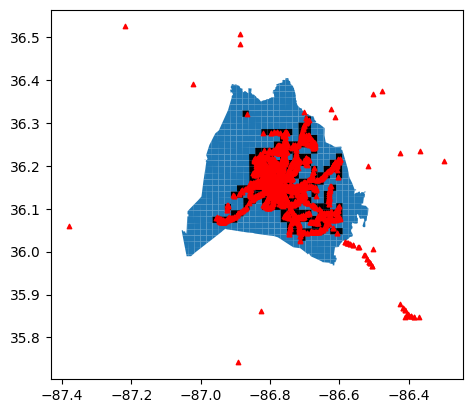

In [129]:
ax = dav_grids2.plot()
dav_grids2.loc[grids_with_incidents_and_roads].plot(color='k', ax=ax)
stops.plot(ax=ax, marker='^', color='red', markersize=10)

In [62]:
grids_with_incidents_and_roads = list(set(list(grid_incidents.keys())) & set(list(grid_stops.keys())))
grids_with_incidents_and_roads.sort()

## Running on a single grid
* For testing

<AxesSubplot: >

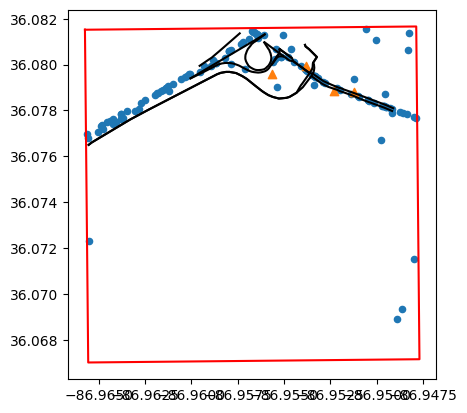

In [63]:
# spot check
import random
k = 63 # good example
# k = random.choice(list(grid_incidents.keys()))
incident_idx = grid_incidents[k]
poly = dav_grids2.iloc[k].geometry
ax = waze_df.loc[incident_idx].plot(markersize=20)
# ax = waze_df.loc[incident_idx].query("date == '2022-11-22'").plot(markersize=100)
ax.plot(*poly.exterior.xy, color='red')
inrix_grouped[inrix_grouped.within(poly)].plot(ax=ax, color='k')
# routes[routes.intersects(poly)].plot(ax=ax, color='red')
stops.loc[grid_stops[k]].plot(marker='^', ax=ax)

In [12]:
apc_data = spark.read.load('data/tt_to_next_stop_2022_04_31.parquet')
apc_data.createOrReplaceTempView("apc")
apc_data.show(1)

+-------------------+--------+-------+----------------+-------------+----+-------------------+-------------------+------------+-------------------+---------------+
|       transit_date|route_id|trip_id|stop_id_original|stop_sequence|load|     departure_time|     scheduled_time|next_stop_id|       next_arrival|tt_to_next_stop|
+-------------------+--------+-------+----------------+-------------+----+-------------------+-------------------+------------+-------------------+---------------+
|2020-01-01 00:00:00|      14| 193713|         MCC4_20|            1| 2.0|2020-01-01 15:20:40|2020-01-01 15:15:00|     UNI2AEF|2020-01-01 15:22:14|           94.0|
+-------------------+--------+-------+----------------+-------------+----+-------------------+-------------------+------------+-------------------+---------------+
only showing top 1 row



# Process
* For each grid (can be done in parallel)
    * filter the apc data for the stops
    * Match with the incident times given some time buffer
    * Sample by N minutees and get the mean travel time for all pairs of stops for that time period
        * Not if there are incidents present on those times

In [113]:
TOLERANCE = "10min"
dr = pd.date_range("2020-01-01 00:00:00", "2022-12-31 23:59:59", freq="10min")
dr = list(zip(dr, dr[1:]))

all_df = []
for k in grids_with_incidents_and_roads:
# for k in random.sample(grids_with_incidents_and_roads, 1):
    # print(k)
    _grid_incidents_idx = grid_incidents[k]
    _grid_stops_idx = grid_stops[k]
    
    # poly = dav_grids2.iloc[k].geometry
    # ax = waze_df.loc[_grid_incidents_idx].plot(markersize=20)
    # ax.plot(*poly.exterior.xy, color='red')
    # inrix_grouped[inrix_grouped.within(poly)].plot(ax=ax, color='k')
    # stops.loc[_grid_stops_idx].plot(marker='^', ax=ax)
    
    _grid_stops = stops.loc[_grid_stops_idx]
    _grid_stops = _grid_stops.stop_id.tolist()
    _apc_data = apc_data.filter(F.col("stop_id_original").isin(_grid_stops))
    df = _apc_data.toPandas()
    
    _grid_incidents = waze_df.loc[_grid_incidents_idx]
    _grid_incidents = _grid_incidents.set_index('datetime').sort_index()
    _grid_incidents['incident'] = 1

    i = 0
    df_arr = []
    for _, v in df.groupby('stop_id_original'):
        v = v.dropna(subset='departure_time')
        v = v.set_index('departure_time')
        v = v.sort_index()
        v = pd.merge_asof(v, _grid_incidents[['street', 'date', 'hour', 'minute', 'second', 'subtype', 'confidence', 'reliability', 'magvar', 'geometry', 'incident']], 
                          left_index=True, right_index=True, tolerance=pd.Timedelta(TOLERANCE))
        v['incident'] = v['incident'].fillna(value=0, inplace=False)
        df_arr.append(v)

    if len(df_arr) > 0:
        merged_df = pd.concat(df_arr)
        merged_df.sort_index()
        merged_df = merged_df.query("tt_to_next_stop >= 0")
        merged_df = merged_df.dropna(subset='tt_to_next_stop')
        merged_df['stop_pairs'] = merged_df["stop_id_original"] + "_" + merged_df["next_stop_id"]
        
        df_arr = []
        for stop_pair, stop_pair_df in merged_df.groupby('stop_pairs'):
            a = stop_pair_df.resample("10min").agg({'tt_to_next_stop':'mean', 'incident':'max'}).dropna()
            a = a.loc[a['tt_to_next_stop'].shift() != a['tt_to_next_stop']]
            # a = stop_pair_df.resample("10min").agg({'tt_to_next_stop':'mean', 'incident':'max'}).bfill()
            a['stop_pair'] = stop_pair
            df_arr.append(a)
    
        if len(df_arr) > 0:
            merged_df = pd.concat(df_arr)
            merged_df['grid_id'] = k
            all_df.append(merged_df)
    # break
all_df = pd.concat(all_df)
all_df.to_parquet(path='data/processed_tt_incident_data_per_grid.parquet')

245


[                     tt_to_next_stop  incident          stop_pair  grid_id
 departure_time                                                            
 2020-06-01 06:30:00           1030.0       0.0    ABBANEN_ABBANEN      245
 2020-06-01 07:00:00            936.0       0.0    ABBANEN_ABBANEN      245
 2020-06-01 07:30:00            936.0       0.0    ABBANEN_ABBANEN      245
 2020-06-01 08:00:00            936.0       0.0    ABBANEN_ABBANEN      245
 2020-06-01 08:30:00            936.0       0.0    ABBANEN_ABBANEN      245
 ...                              ...       ...                ...      ...
 2022-04-30 20:30:00             22.0       0.0  SHAORIEN_SHABELEN      245
 2022-04-30 21:00:00             22.0       0.0  SHAORIEN_SHABELEN      245
 2022-04-30 21:30:00             22.0       0.0  SHAORIEN_SHABELEN      245
 2022-04-30 22:00:00             22.0       0.0  SHAORIEN_SHABELEN      245
 2022-04-30 22:30:00             22.0       0.0  SHAORIEN_SHABELEN      245
 
 [650594 r

In [116]:
all_df = pd.concat(all_df)
all_df.to_parquet(path='data/processed_tt_incident_data_per_grid.parquet')

# Analysis and further processing

In [62]:
# all_df = pd.concat(all_df)
all_df = pd.read_parquet(path='data/processed_tt_incident_data_per_grid.parquet')

In [63]:
for k, v in all_df.groupby('stop_pair'):
    if not v.query("incident == 1").empty:
        display(v)
        v['hour'] = v.index.hour
        v['minute'] = v.index.minute
        break
factor_arr = []
for k, vv in v.query("incident == 1").iterrows():
    pre_k = k - pd.Timedelta('30min')
    post_k = k + pd.Timedelta('30min')
    # print(pre_k, k, post_k)
    # display(v[pre_k:post_k])
    pre_df = v[pre_k:k]
    post_df = v[k:post_k]
    pre_k_tt = pre_df.tt_to_next_stop.mean()
    post_k_tt = post_df.tt_to_next_stop.mean()
    factor = post_k_tt/pre_k_tt
    print(k, factor)
    # display(pre_df)
    # display(post_df)
    # break

,tt_to_next_stop,incident,stop_pair,grid_id
2020-01-01 06:40:00,5.0,0.0,100OAKS_POWPOWNM,320
2020-01-01 07:40:00,6.0,0.0,100OAKS_POWPOWNM,320
2020-01-01 11:50:00,8.0,0.0,100OAKS_POWPOWNM,320
2020-01-01 12:40:00,7.0,0.0,100OAKS_POWPOWNM,320
2020-01-01 13:40:00,8.0,0.0,100OAKS_POWPOWNM,320
...,...,...,...,...
2022-04-30 17:00:00,8.0,0.0,100OAKS_POWPOWNM,320
2022-04-30 17:40:00,6.0,0.0,100OAKS_POWPOWNM,320
2022-04-30 18:40:00,8.0,0.0,100OAKS_POWPOWNM,320
2022-04-30 19:40:00,6.0,0.0,100OAKS_POWPOWNM,320


2020-10-22 18:40:00 1.0
2021-03-03 21:40:00 1.0
2021-03-26 12:40:00 0.7894736842105263
2021-03-31 11:40:00 1.0
2021-03-31 13:40:00 1.0
2021-05-27 20:40:00 1.0
2021-06-03 22:40:00 1.0
2021-07-07 14:50:00 1.0
2021-07-21 11:30:00 1.0
2021-08-09 12:50:00 1.0
2021-08-13 20:40:00 1.0
2021-10-01 19:40:00 1.0
2021-10-07 14:00:00 1.0
2021-10-07 14:20:00 1.2307692307692308
2021-10-20 14:50:00 0.9859154929577465
2021-10-22 21:40:00 1.0
2021-11-03 22:40:00 1.0
2021-11-17 22:40:00 1.0
2021-12-05 20:40:00 1.0
2021-12-05 21:40:00 1.0
2021-12-07 21:50:00 1.0
2021-12-14 16:20:00 1.1764705882352942
2022-02-16 22:40:00 1.0
2022-03-07 14:00:00 1.0
2022-04-11 13:30:00 0.7857142857142857


### Loop through all incidents, get travel time for that and travel time for past 30 minutes, see change.

In [100]:
from multiprocessing import Pool, cpu_count

def getFactors(tuple_df):
    stop_pair = tuple_df[0]
    df = tuple_df[1]
    factor_arr = []
    for kk, vv in df.query("incident == 1").iterrows():
        pre_k = kk - pd.Timedelta('30min')
        post_k = kk + pd.Timedelta('30min')
        pre_df = v[pre_k:kk]
        post_df = v[kk:post_k]
        pre_k_tt = pre_df.tt_to_next_stop.mean()
        post_k_tt = post_df.tt_to_next_stop.mean()
        factor = post_k_tt/pre_k_tt
        factor_arr.append((kk, factor, stop_pair))
        
    if len(factor_arr) > 0:
        factor_arr = pd.DataFrame(factor_arr, columns=['timestamp', 'tt_incident_factor', 'stop_pair'])
    if isinstance(factor_arr, list):
        factor_arr = pd.DataFrame()
    return factor_arr

def applyParallel(dfGrouped, func):
    with Pool(3) as p:
        ret_list = p.map(func, [(name, group) for name, group in dfGrouped])
    return pd.concat(ret_list)

all_df = pd.read_parquet(path='data/processed_tt_incident_data_per_grid.parquet')
dfGrouped = all_df.groupby('stop_pair')
all_factors_df = applyParallel(dfGrouped, getFactors)
all_factors_df.replace([np.inf, -np.inf], np.nan, inplace=True)
all_factors_df.dropna(subset=["tt_incident_factor"], how="all", inplace=True)
all_factors_df.to_parquet(path='data/processed_tt_incident_factor_per_stop_pair.parquet')